In [1]:
from functools import reduce
import numpy as np
import os
import pandas as pd
import pickle
import re
from string import punctuation
import subprocess
from tqdm import tqdm

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


def plot_matrix(cm, xticklabels, yticklabels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=yticklabels,
           title=title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
data_path = 'SemEval-2023-task3-corpus-main/data/en/'

In [4]:
articles_paths = sorted(os.listdir(os.path.join(data_path, 'train-articles-subtask-3/')))

In [5]:
with open(os.path.join(data_path, 'train-articles-subtask-3/', articles_paths[0]), 'r') as f:
    article_text = f.read()

In [6]:
labels_dict = {}
articles_content = {}

for article_path in articles_paths:

    with open(os.path.join(data_path, 'train-articles-subtask-3/', article_path), 'r') as f:
        article_text = f.read().strip()
        articles_content[article_path] = article_text

    with open(os.path.join(data_path, 'train-labels-subtask-3-spans/',
                           article_path.replace('.txt', '-labels-subtask-3.txt')), 'r') as f:
        labels_text = f.read().strip().split('\n')

        labels_dict[article_path] = []
        for row in labels_text:
            row = row.split('\t')
            if len(row) > 1:
                labels_dict[article_path].append([row[1], int(row[2]), int(row[3])])

In [42]:
with open('full_parsed_result_train_v2.pkl', 'rb') as f:
    parsed_data = pickle.load(f)

In [8]:
len(parsed_data)

308

In [12]:
def get_info_path(dt, leaf_num):
    perlevel_info = {}
    count_by_levels = {}
    
    for row in dt.split('\n'):
        level = (len(row) - len(row.lstrip())) // 2
        if 'rel2par' in row:
            if level in count_by_levels:
                count_by_levels[level] += 1
            else:
                count_by_levels[level] = 1
            perlevel_info[level] = [row.strip().split()[1], re.findall(r'rel2par ([^\)]*)\)', row)[0]]
        leaf_num_cur = re.findall(r'\(leaf (\d+)\)', row)
        if len(leaf_num_cur) > 0:
            leaf_num_cur = int(leaf_num_cur[0])
            if leaf_num_cur == leaf_num:
                path = [count_by_levels[l] % 2 * (-2) + 1 for l in range(1, level+1)]
                return ({l: v for (l,v) in perlevel_info.items() if l <= level}, path)

In [13]:
print(parsed_data['article111111111.txt']['dt'])

( Root (span 1 56)
  ( Nucleus (span 1 6) (rel2par span)
    ( Nucleus (leaf 1) (rel2par span) (text _!Next plague outbreak in Madagascar could be ' stronger ' :_!) )
    ( Satellite (span 2 6) (rel2par Elaboration)
      ( Nucleus (span 2 4) (rel2par Contrast)
        ( Satellite (leaf 2) (rel2par Attribution) (text _!WHO_!) )
        ( Nucleus (span 3 4) (rel2par span)
          ( Satellite (leaf 3) (rel2par Attribution) (text _!Geneva - The World Health Organisation chief on Wednesday said_!) )
          ( Nucleus (leaf 4) (rel2par span) (text _!a deadly plague epidemic appeared to have been brought under control in Madagascar ,_!) )
        )
      )
      ( Nucleus (span 5 6) (rel2par Contrast)
        ( Satellite (leaf 5) (rel2par Attribution) (text _!but warned_!) )
        ( Nucleus (leaf 6) (rel2par span) (text _!the next outbreak would likely be stronger ._!) )
      )
    )
  )
  ( Satellite (span 7 56) (rel2par Elaboration)
    ( Nucleus (span 7 10) (rel2par span)
      ( N

In [14]:
for i in parsed_data['article111111111.txt']['edu_spans']:
    print(i, get_info_path(parsed_data['article111111111.txt']['dt'], i)[0])

1 {1: ['Nucleus', 'span'], 2: ['Nucleus', 'span']}
2 {1: ['Nucleus', 'span'], 2: ['Satellite', 'Elaboration'], 3: ['Nucleus', 'Contrast'], 4: ['Satellite', 'Attribution']}
3 {1: ['Nucleus', 'span'], 2: ['Satellite', 'Elaboration'], 3: ['Nucleus', 'Contrast'], 4: ['Nucleus', 'span'], 5: ['Satellite', 'Attribution']}
4 {1: ['Nucleus', 'span'], 2: ['Satellite', 'Elaboration'], 3: ['Nucleus', 'Contrast'], 4: ['Nucleus', 'span'], 5: ['Nucleus', 'span']}
5 {1: ['Nucleus', 'span'], 2: ['Satellite', 'Elaboration'], 3: ['Nucleus', 'Contrast'], 4: ['Satellite', 'Attribution']}
6 {1: ['Nucleus', 'span'], 2: ['Satellite', 'Elaboration'], 3: ['Nucleus', 'Contrast'], 4: ['Nucleus', 'span']}
7 {1: ['Satellite', 'Elaboration'], 2: ['Nucleus', 'span'], 3: ['Nucleus', 'span']}
8 {1: ['Satellite', 'Elaboration'], 2: ['Nucleus', 'span'], 3: ['Satellite', 'Attribution'], 4: ['Nucleus', 'span']}
9 {1: ['Satellite', 'Elaboration'], 2: ['Nucleus', 'span'], 3: ['Satellite', 'Attribution'], 4: ['Satellite', 'Sa

## EDU-intersection

In [12]:
from collections import defaultdict
import portion as P

In [13]:
def calc_iu(span1, span2):
    intersection = max(min(span1[1], span2[1]) - max(span1[0], span2[0]), 0)
    union = span1[1] - span1[0] + span2[1] - span2[0] - intersection
    return intersection, union

In [14]:
def calc_iu_lists(span_list_1, span_list_2):
    sum_intersection_len = 0
    list_1_portion = reduce(lambda x, y: x|y, [P.closed(el[0], el[1]) for el in span_list_1]) if len(span_list_1) > 0 else []
    list_2_portion = reduce(lambda x, y: x|y, [P.closed(el[0], el[1]) for el in span_list_2]) if len(span_list_2) > 0 else []
    if len(list_1_portion) > 0:
        if len(list_2_portion) > 0:
            union = list_1_portion | list_2_portion
            intersection = list_1_portion & list_2_portion
        else:
            union = list_1_portion
            intersection = []
    else:
        if len(list_2_portion) > 0:
            union = list_2_portion
            intersection = []
        else:
            union = []
            intersection = []
    return {
        'intersection': sum([el[2] - el[1] for el in P.to_data(intersection)]),
        'union': sum([el[2] - el[1] for el in P.to_data(union)]),
        'len1': sum([el[2] - el[1] for el in P.to_data(list_1_portion)]),
        'len2': sum([el[2] - el[1] for el in P.to_data(list_2_portion)])
    }

In [15]:
count_total = defaultdict(int)
miou_edus = defaultdict(int)
for key in tqdm(parsed_data):
    for name, span_start, span_end in labels_dict[key]:
        if 'edu_spans' in parsed_data[key]:
            count_total[name] += 1
            edu_spans_list = parsed_data[key]['edu_spans'].values() # еще кривые границы
            inter_spans = [s for s in edu_spans_list if calc_iu_lists([(span_start, span_end)], [s])['intersection'] > 0]
            if len(inter_spans) > 0:
                iu = calc_iu_lists([(span_start, span_end)], inter_spans)
                if iu['intersection'] > 0:
                    miou_edus[name] += iu['intersection'] / iu['union']
for name in miou_edus:
    miou_edus[name] /= count_total[name]

100%|████████████████████████████████████████████████████████████████████████████████| 446/446 [01:11<00:00,  6.21it/s]


In [16]:
res_df = pd.DataFrame()
res_df['name'] = count_total.keys()
res_df['cnt'] = [count_total[k] for k in res_df['name']]
res_df['edu_miou'] = [miou_edus[k] for k in res_df['name']]
res_df = res_df.sort_values(by='cnt', ascending=False)

In [17]:
res_df

,name,cnt,edu_miou
5,Loaded_Language,1671,0.403801
8,Name_Calling-Labeling,887,0.379411
2,Repetition,496,0.389009
0,Doubt,391,0.895128
7,Exaggeration-Minimisation,328,0.629021
3,Appeal_to_Fear-Prejudice,269,0.830944
13,Flag_Waving,239,0.659549
6,Causal_Oversimplification,179,0.910018
1,Appeal_to_Authority,129,0.878365
11,Slogans,116,0.661067


In [18]:
res_filt = res_df[(res_df.cnt > 50) & (res_df.edu_miou > 0.8)]
res_filt

,name,cnt,edu_miou
0,Doubt,391,0.895128
3,Appeal_to_Fear-Prejudice,269,0.830944
6,Causal_Oversimplification,179,0.910018
1,Appeal_to_Authority,129,0.878365
9,False_Dilemma-No_Choice,97,0.882206


In [19]:
names_filt = list(res_df.name.values)

## Nucleus / satellite

In [20]:
nuc_sat = ['Nucleus', 'Satellite']
count_total = {n: {r: 0 for r in nuc_sat} for n in names_filt}
count_rels_iou = {n: {r: 0 for r in nuc_sat} for n in names_filt}
count_rels_spancov = {n: {r: 0 for r in nuc_sat} for n in names_filt}
count_rels_relscov = {n: {r: 0 for r in nuc_sat} for n in names_filt}

for key in tqdm(parsed_data):
    if 'edu_spans' in parsed_data[key]:
        edu_spans_list = list(parsed_data[key]['edu_spans'].values())
        relations_nuc_sat = [list(get_info_path(parsed_data[key]['dt'], i)[0].values())[-1][0] for i 
                             in range(1, len(edu_spans_list)+1)]

        for name in res_df.name.values:
            name_spans = [s[1:] for s in labels_dict[key] if s[0] == name]
            if len(name_spans) > 0:
                for rel in nuc_sat:
                    rel_spans = [edu_spans_list[i] for i in range(len(edu_spans_list)) if relations_nuc_sat[i] == rel]
                    if len(rel_spans) > 0:
                        count_total[name][rel] += 1
                        #iou_res =  calc_iu_lists([(span_start, span_end)], rel_spans)
                        iou_res =  calc_iu_lists(name_spans, rel_spans)
                        count_rels_iou[name][rel] += iou_res['intersection'] / iou_res['union']
                        count_rels_spancov[name][rel] += iou_res['intersection'] / iou_res['len1']
                        count_rels_relscov[name][rel] += iou_res['intersection'] / iou_res['len2']
            
for name in count_rels_iou:
    for rel in count_rels_iou[name]:
        count_rels_iou[name][rel] /= count_total[name][rel]
        count_rels_spancov[name][rel] /= count_total[name][rel]
        count_rels_relscov[name][rel] /= count_total[name][rel]

100%|████████████████████████████████████████████████████████████████████████████████| 446/446 [01:17<00:00,  5.78it/s]


In [21]:
all_names = list(count_rels_iou.keys())

<Axes: title={'center': 'IOU'}>

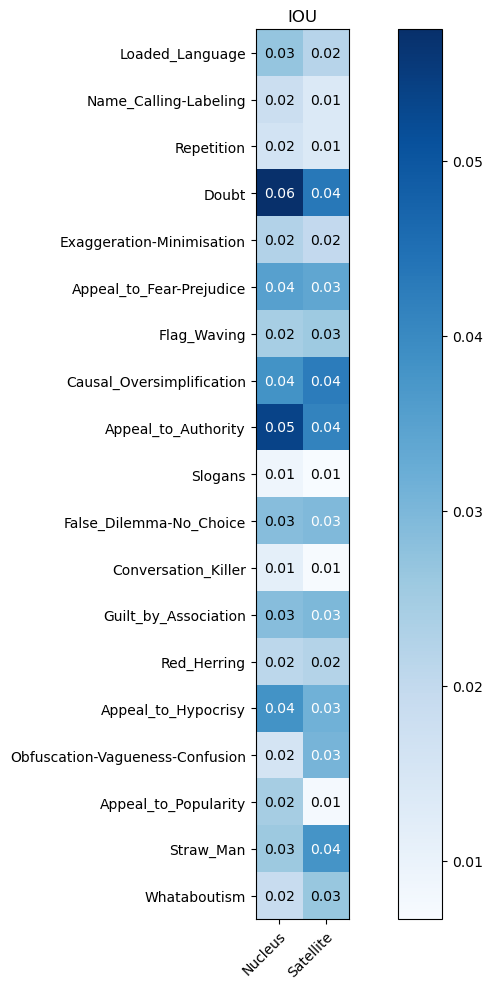

In [22]:
mat = np.array([[count_rels_iou[name][rel] for rel in nuc_sat] for name in all_names])
plot_matrix(mat, nuc_sat, all_names, title='IOU')

<Axes: title={'center': 'Propaganda span coverage'}>

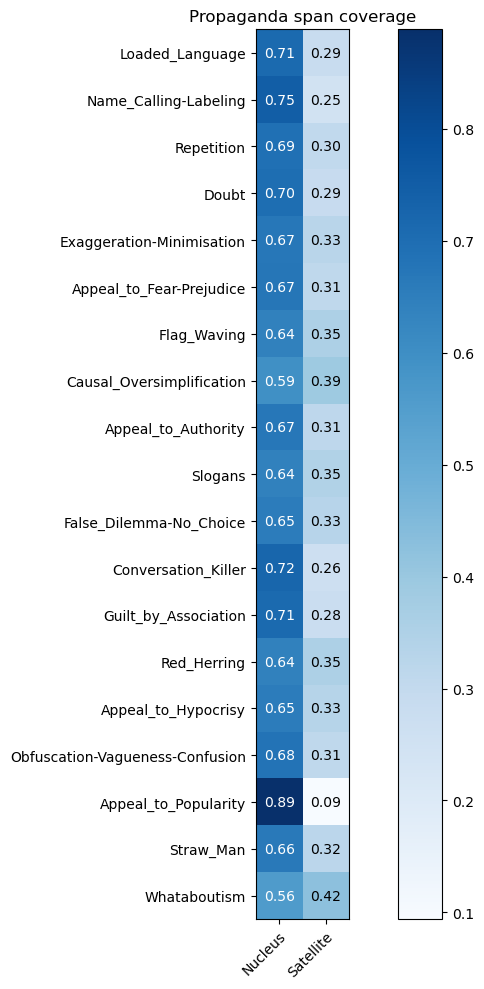

In [23]:
mat = np.array([[count_rels_spancov[name][rel] for rel in nuc_sat] for name in all_names])
plot_matrix(mat, nuc_sat, all_names, title='Propaganda span coverage')

<Axes: title={'center': 'Relation coverage'}>

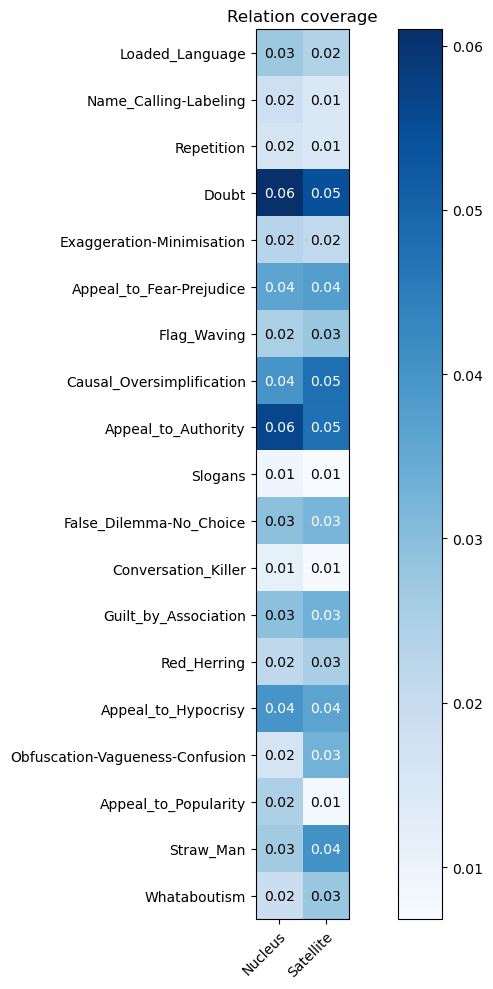

In [24]:
mat = np.array([[count_rels_relscov[name][rel] for rel in nuc_sat] for name in all_names])
plot_matrix(mat, nuc_sat, all_names, title='Relation coverage')

## Relations

In [28]:
def plot_matrix(cm, xticklabels, yticklabels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, suff=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots(figsize=(11,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=yticklabels,
           title=title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=8,
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=8,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(f'figures/distr_rels_{suff}.pdf', pad_inches=0., bbox_inches=0.)
    return ax

In [164]:
def plot_matrix_2_cols(cm, xticklabels, yticklabels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, suff=''):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    fig, ax = plt.subplots(figsize=(11,5.5))
    
    cm2 = [[None for _ in range(len(cm[0]))] for _ in range(len(cm))]
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            if (cm[i][j] >0.06 or  cm[i][j] > 0.95 * max([cm[i][k] for k in range(len(cm[i])) if k not in [6,10,12]])) and j not in [6,10,12]:
                cm2[i][j] = cm[i][j]
    cm2 = np.array(cm2, dtype=np.float16)
    
#     cm_plot = deepcopy(cm)
#     cm_plot[cm2 != np.float16(None)] = np.nan
#     print(cm_plot, cm2)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=truncate_colormap(cmap, minval=0, maxval=0.8), aspect='auto')
    im2 = ax.imshow(cm2, interpolation='nearest', cmap=truncate_colormap(plt.cm.Greens, minval=0.2, maxval=0.7), aspect='auto')
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=yticklabels,
           title=title)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", fontsize=8,
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() * 2./3
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=8,
                    color="white" if (cm[i, j] > thresh or cm2[i][j] > 0.14) else "black")
    fig.tight_layout()
    plt.savefig(f'figures/distr_rels_{suff}.pdf', pad_inches=0., bbox_inches=0.)
    return ax

In [25]:
def get_rel(dt, i):
    path_info = get_info_path(dt, i)[0]
    for el in list(path_info.values())[::-1]:
        if el[1] != 'span':
            return el[1]
    return 'span'

In [26]:
all_rels = set()
for key in parsed_data:
    all_rels |= set(re.findall(r'\(rel2par ([\w-]+)\)', parsed_data[key]['dt']))
all_rels = sorted(list(all_rels))

In [27]:
names_filt = res_df.name.values
count_rels_inter = {n: {r: 0 for r in all_rels} for n in names_filt}
count_rels_len_prop = {n: {r: 0 for r in all_rels} for n in names_filt}
count_rels_len_rel = {n: {r: 0 for r in all_rels} for n in names_filt}
count_rels_union = {n: {r: 0 for r in all_rels} for n in names_filt}

count_rels_spancov = {n: {r: 0 for r in all_rels} for n in names_filt}
count_rels_relscov = {n: {r: 0 for r in all_rels} for n in names_filt}
count_rels_rels_iou = {n: {r: 0 for r in all_rels} for n in names_filt}


for key in tqdm(parsed_data):
    if 'edu_spans' in parsed_data[key]:
        edu_spans_list = list(parsed_data[key]['edu_spans'].values()) # еще кривые границы
        relations = [get_rel(parsed_data[key]['dt'], i) for i in range(1, len(edu_spans_list)+1)]

        for name in res_df.name.values:
            name_spans = [s[1:] for s in labels_dict[key] if s[0] == name]
#             if len(name_spans) > 0:
            for rel in all_rels:
                rel_spans = [edu_spans_list[i] for i in range(len(edu_spans_list)) if relations[i] == rel]
#                     if len(rel_spans) > 0:
#                         iou_res =  calc_iu_lists([(span_start, span_end)], rel_spans)
                if len(rel_spans) > 0:
                    iou_res =  calc_iu_lists(name_spans, rel_spans)
                    count_rels_inter[name][rel] += iou_res['intersection']
                    count_rels_union[name][rel] += iou_res['union']
                    count_rels_len_rel[name][rel] += iou_res['len2']
                if len(name_spans) > 0:
                    count_rels_len_prop[name][rel] += iou_res['len1']
            
for name in count_rels_inter:
    for rel in count_rels_inter[name]:
        count_rels_spancov[name][rel] =  count_rels_inter[name][rel] / count_rels_len_prop[name][rel]
        count_rels_relscov[name][rel] = count_rels_inter[name][rel] / count_rels_len_rel[name][rel]
        count_rels_rels_iou[name][rel] = count_rels_inter[name][rel] / count_rels_union[name][rel]

100%|████████████████████████████████████████████████████████████████████████████████| 446/446 [01:35<00:00,  4.69it/s]


In [165]:
list(enumerate(all_rels))

[(0, 'Attribution'),
 (1, 'Background'),
 (2, 'Cause'),
 (3, 'Comparison'),
 (4, 'Condition'),
 (5, 'Contrast'),
 (6, 'Elaboration'),
 (7, 'Enablement'),
 (8, 'Evaluation'),
 (9, 'Explanation'),
 (10, 'Joint'),
 (11, 'Manner-Means'),
 (12, 'Same-Unit'),
 (13, 'Summary'),
 (14, 'Temporal'),
 (15, 'Textual-Organization'),
 (16, 'Topic-Change'),
 (17, 'Topic-Comment'),
 (18, 'span')]

<Axes: >

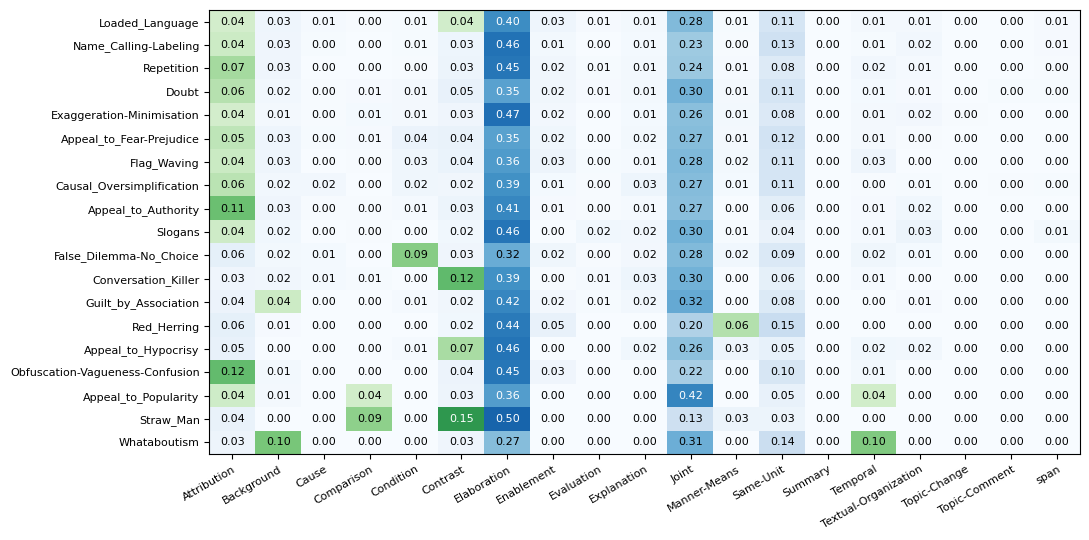

In [166]:
mat = np.array([[count_rels_spancov[name][rel] for rel in all_rels] for name in all_names])
plot_matrix_2_cols(mat, all_rels, all_names, suff='rels') #'Propaganda span coverage'

<Axes: >

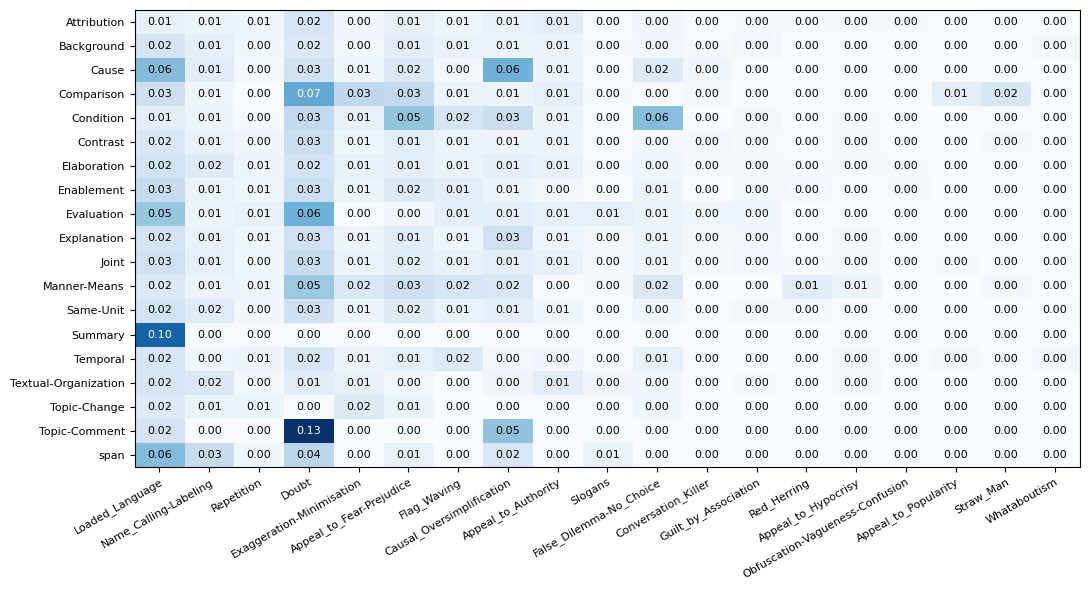

In [114]:
mat = np.array([[count_rels_relscov[name][rel] for rel in all_rels] for name in all_names])
plot_matrix(mat.T, all_names, all_rels, suff='spans')

<Axes: >

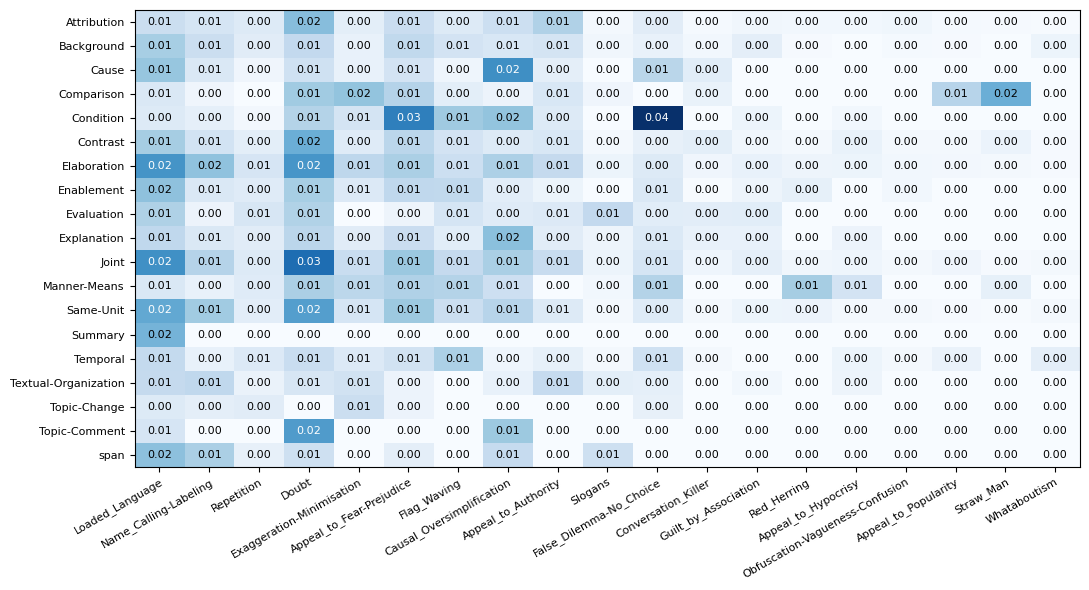

In [115]:
mat = np.array([[count_rels_rels_iou[name][rel] for rel in all_rels] for name in all_names])
plot_matrix(mat.T, all_names, all_rels, suff='iou') 